# Libraries

In [1]:
import os
import pandas as pd
import random
import numpy as np

# tqdm: utility for progession bar
from tqdm.notebook import tqdm

# pytorch: helps us make model
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset

# ml_things: help to genrate predicitve report
!pip install git+https://github.com/gmihaila/ml_things
from ml_things import plot_confusion_matrix

# sklearn: help to genrate predicitve report
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

# huggingface: Stores pre-trained models
from transformers import BertTokenizer, BertForSequenceClassification, set_seed
from transformers import pipeline, AdamW, get_linear_schedule_with_warmup

# wandb: kind of a VCS for reports
import wandb

# json: helps pasring JSON
import json

  Cloning https://github.com/gmihaila/ml_things to /tmp/pip-req-build-h7zi5yn6
  Running command git clone -q https://github.com/gmihaila/ml_things /tmp/pip-req-build-h7zi5yn6
     |████████████████████████████████| 66 kB 824 kB/s eta 0:00:01
  Created wheel for ml-things: filename=ml_things-0.0.1-py3-none-any.whl size=22323 sha256=5039b1895fd91e7fef7448db658a25fdf903ec68598dbf3de1506654b8786d07
  Stored in directory: /tmp/pip-ephem-wheel-cache-bo4pm327/wheels/20/45/02/23a7ab529f33a743dcb6b023bd577920a6f01418b11075789d
  Created wheel for ftfy: filename=ftfy-5.9-py3-none-any.whl size=46451 sha256=b116b9d4c99c30efd2f9c097e9473fc92b2dbc58e819d8a84974153eb452b511
  Stored in directory: /root/.cache/pip/wheels/4f/6b/a5/84880e9435707659c6b96d3aadeb9a87a41f61ec9ede469f41
Successfully built ml-things ftfy


/opt/conda/lib/python3.7/site-packages/wandb/vendor/watchdog/utils/bricks.py:175: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class OrderedSet(collections.MutableSet):


# Environment Variables

In [2]:
# init wandb project
wandb.init(project="stumbleupon")

# logs config
config = wandb.config

# Lets set a seed
## Ensures easy reproducibility
config.seed = seed = 69
set_seed(config.seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Number of epochs to train for
config.epoch = epoch = 3 

# Batch size for training
config.batch = batch = 8

# learniing rate
config.lr = lr = 1e-5

# scheduler warm steps
config.warup_steps = warup_steps = 0

# Each model has number of words they can process
# Setting sequence length
config.maxLength = maxLength = 512

# This chooses GPU for training if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model which we choose from huggingface/tranformers library
config.modelName = modelName = 'bert-base-uncased'


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.7/site-packages/tornado/httputil.py:105: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class HTTPHeaders(collections.MutableMapping):
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.10.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Data Preprocesing

In [3]:
df = pd.read_table('/kaggle/input/stumbleupon/train.tsv')
dfTest = pd.read_table('/kaggle/input/stumbleupon/test.tsv')
dfSub = pd.read_csv('/kaggle/input/stumbleupon/sampleSubmission.csv')

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


BERT could only process 512 token, so I need to process the boilerplate text to include most crucial data.

In [15]:
def boilerplatePreproc(data):
    '''
        This function helps us preproc the data stored in the boilerplate column. This function only takes 'body' of the article in account as
        article body contains the context needed to classify article as evergreen or ephemeral. Furthermore, we filter out last 512 words from the
        body as they are generally concluding statement hence has article summary.
    '''
    jsonData = json.loads(data)
    
    # if JSON has no body, we will substitute the body with title
    try:
        x = jsonData['body']
        x = ' '.join(x.split(' ')[-400:])
    except:
        x = jsonData['title']
        
    return x

# applies above func and stores result in a new column
df['body'] = df.boilerplate.map(boilerplatePreproc)
df = df.dropna()
dfTest['body'] = dfTest.boilerplate.map(boilerplatePreproc)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's check for class imbalance

In [16]:
df.label.value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1    3796
0    3598
Name: label, dtype: int64

Perfectly balanced, as all things should be.

Now let's move onto embeddings.

In [17]:
# split dataset into train and val for validating model performance
x_train, x_val, y_train, y_val = train_test_split(df.body.values, df.label.values, test_size=0.15, random_state=seed, stratify=df.label.values)

# init tokenizer
tokenizer = BertTokenizer.from_pretrained(modelName, do_lower_case=True)

# get embedings
encoded_data_train = tokenizer.batch_encode_plus(
    list(x_train), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    #pad_to_max_length=True, 
    padding='max_length',
    max_length=maxLength, 
    return_tensors='pt',
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    list(x_val), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    #pad_to_max_length=True,
    padding='max_length', 
    max_length=maxLength, 
    return_tensors='pt',
    truncation=True
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(list(y_train))#.float()

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(list(y_val))#.float()

# making dataset
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# making dataloader
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch)
dataloader_val = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Model Helper Functions

In [7]:
# helper that init model obj
def initHelper():
    # get pretrained model
    # model = BertForSequenceClassification.from_pretrained(modelName, num_labels=2, output_attentions=False, output_hidden_states=False)
    model = BertForSequenceClassification.from_pretrained(modelName)
    model = model.to(device)

    # get optimizer
    optimizer = AdamW(model.parameters(), lr=lr, eps=2e-8)

    # init scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warup_steps, num_training_steps=len(dataloader_train) * epoch)
    
    return model, optimizer, scheduler

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# helper that validates the model
def evaluate():

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1],
            'labels':         batch[2],
        }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Helper that calcs f1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

# Helper that trains the model
def trainHelper(epoch):
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        # zero previous step's grad
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1],
            'labels':         batch[2],
        }       

        outputs = model(**inputs)
        
        # calc loss
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.float().backward()

        # clips from to 1, prevents exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # perform optimizer and scheduler steps
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    # save model    
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.pth')
    wandb.save(f'finetuned_BERT_epoch_{epoch}.pth')
    
    tqdm.write(f'\nEpoch {epoch}')
    
    # log loss
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    # log val report
    val_loss, predictions, true_vals = evaluate()
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    # log to wandb
    wandb.log({
        'epoch': epoch,
        'loss': loss_train_avg,
        'validation loss': val_loss,
        'f1 score': val_f1,
    })

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Train Model

In [12]:
# get model obj
model, optimizer, scheduler = initHelper()

# log model in wandb
wandb.watch(model)

# train model
for i in tqdm(range(1, epoch+1)):
    trainHelper(i)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTra

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/786 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.47304118563049014
Validation loss: 0.46238803005904605
F1 Score (Weighted): 0.7871674817669926


Epoch 2:   0%|          | 0/786 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3904070742191325
Validation loss: 0.4847552280256645
F1 Score (Weighted): 0.7912367832136816


Epoch 3:   0%|          | 0/786 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.30004163101343934
Validation loss: 0.5503312715684339
F1 Score (Weighted): 0.7843854750914923


# Creating Pipeline

In [49]:
# Helper that predicts the class of the article
def predLabels(data):
    encoded_data = tokenizer.batch_encode_plus(
        data, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        #pad_to_max_length=True,
        padding='max_length', 
        max_length=maxLength, 
        return_tensors='pt',
        truncation=True
    )
    
    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    
    dataset = TensorDataset(input_ids, attention_masks)
    dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=1)
    
    model.eval()
    
    predictions = []
    
    for batch in dataloader:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1],
#             'labels':         batch[2],
        }

        with torch.no_grad():        
            outputs = model(**inputs)
        
#         print(outputs[0])
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        predictions.append(logits)
    
    predictions = np.concatenate(predictions, axis=0)
            
    return np.argmax(predictions, axis=1).flatten()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Confusion matrix, without normalization


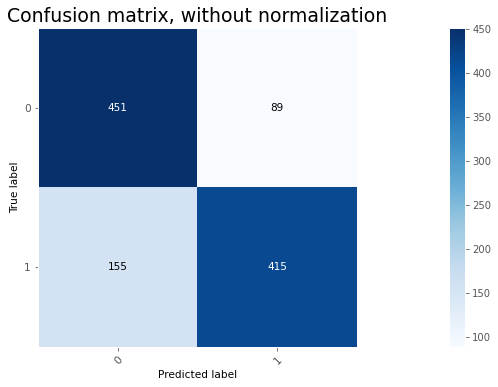

In [53]:
# Validation data list
x_val_list = list(x_val)
y_val_list = list(y_val)

# Make predictions
pred = predLabels(x_val_list)
    
# plot conf matrix
plot_confusion_matrix(y_val_list, pred)

# wandb
wandb.log({
    "conf_mat" : wandb.plot.confusion_matrix(
                    probs=None,
                    y_true=y_val_list,
                    preds=pred,
                    class_names=['ephemeral', 'evergreen']
                ),
})

# Generating Submission File

In [54]:
preds = predLabels(dfTest.body.to_list())

subDict = {
    'urlid': dfTest.urlid.to_list(),
    'label': preds,
}

dfSub = pd.DataFrame.from_dict(subDict)
dfSub.to_csv('submission.csv', index = False)
wandb.save(f'submission.csv')
# dfSub.head()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,urlid,label
0,5865,1
1,782,0
2,6962,1
3,7640,0
4,3589,0
